# Replication Project for Network Science Course
## Paper: An edge-centric perspective on the human connectome: link communities in the brain, by Marcel A. de Reus, Victor M. Saenger, René S. Kahn and Martijn P. van den Heuvel
## Student: Yee Sern Tan

The dataset is obtained from http://www.myconnectome.nl/wordpress/wp-content/uploads/grouped_umcu50_60percent.mat, courtesy of the Dutch Connectome Lab. It is converted into Network.csv for loading.

In [2]:
import os
import csv
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn import linear_model
import scipy
import operator
%matplotlib inline

input_file = 'Network.csv'

if os.path.isfile(input_file) == False:
    print(input_file + ' file doesn\'t exist.')
    exit()

In [3]:
## Read file and check size of array
array = []
with open(input_file, "rt", encoding="utf8") as input_csv:
    input_reader = csv.reader(input_csv, delimiter=',')
    for entry in input_reader:
        if len(entry) != 68:
            print("row length error {}".format(len(entry)))
        row = [int(item) for item in entry]
        array.append(row)
    if len(array) != 68:
        print("array length error {}".format(len(array)))
input_csv.close()

In [4]:
## Convert to NetworkX graph
np_matrix = np.matrix(array)
G = nx.from_numpy_matrix(np_matrix)
print(nx.info(G))

# G_line is the line graph
G_line = nx.line_graph(G)
print(nx.info(G_line))

# dict_G_line gives values the 1-indexed edge number for each edge as key
dict_G_line = {}
# dict_G_line_reverse gives values the edge as node-pair for each edge number as key
dict_G_line_reverse = {}

Name: 
Type: Graph
Number of nodes: 68
Number of edges: 383
Average degree:  11.2647
Name: 
Type: Graph
Number of nodes: 383
Number of edges: 4698
Average degree:  24.5326


In [5]:
# Make G_line a weighted graph and output into a txt file
iter_edge = 1
for edge in G_line.nodes():
    dict_G_line[edge] = iter_edge
    dict_G_line_reverse[iter_edge] = edge
    iter_edge += 1
with open("line_graph.txt", "w") as f:
    f.write("# A network in link list format\n")
    for edge_link in G_line.edges():
        shared_node = -1
        for end_point0 in edge_link[0]:
            for end_point1 in edge_link[1]:
                if end_point0 == end_point1:
                    shared_node = end_point0
        if shared_node == -1:
            print("This is an error no common node")
            exit()
        end1 = dict_G_line[edge_link[0]]
        end2 = dict_G_line[edge_link[1]]
        weight = 1 / ( G.degree(shared_node) - 1)
        str_write = "{}\t{}\t{}\n".format(end1, end2,weight)
        f.write(str_write)
        G_line[edge_link[0]][edge_link[1]]['weight'] = weight
f.close()

A C++ program processes "line_graph.txt" into "line_graph.clu" containing communities contained here.
The program, developed by Daniel Edler and Martin Rosvall, is under open source GNU Affero General Public License, and can be available at http://www.mapequation.org/code.html.
The installation steps depend on the Operating System. It compiles and runs under a Unix-like environment.
The algorithm can be run with the following command: 

./Infomap -i link-list --num-trials 3000 --map --clu --tree <read_directory/line_graph.txt> <write_directory>. 

The format of the output "line_graph.clu" is as follows
Column 0: the nodes of line graph, that is the edges of original graph
Column 1: the edge_community to which the edge of original graph belongs

In [6]:
# edge_community_node_index has key node and value a set of edge communities the node is adjacent
edge_community_node_index = {}
# edge_community_edge_index has key edge and value community
edge_community_edge_index = {}
communities = []
with open("line_graph.clu") as f:
    line_number = 0
    for line in f:
        if line_number < 2:
            line_number += 1
            continue
        line.rstrip('\n')
        community_read_info = line.split(' ')
        community = int(community_read_info[1])
        edge = dict_G_line_reverse[int(community_read_info[0])]
        if edge[0] not in edge_community_node_index:
            edge_community_node_index[edge[0]] = []
        edge_community_node_index[edge[0]].append(community)
        if edge[1] not in edge_community_node_index:
            edge_community_node_index[edge[1]] = []
        edge_community_node_index[edge[1]].append(community)
        edge_community_edge_index[edge] = community
        if community not in communities:
            communities.append(community)

In [7]:
# calculates the community ownership of the node
def calc_edge_community_ownership(node):
    total_count = 0
    counts = {}
    for community in edge_community_node_index[node]:
        if community not in counts:
            counts[community] = 1
        else:
            counts[community] += 1
        total_count += 1
    ownership = {}
    max_count = 0
    max_community = []
    for community in counts:
        ownership[community] = counts[community]/total_count
        if counts[community] > max_count:
            max_count = counts[community]
            max_community = [community]
        elif counts[community] == max_count:
            max_community.append(community)
    # max_community is the list of edge_communities for whcih that node has the most links adjacent to it
    # total_count is the number of edge_communities that node is adjacent to
    # ownership is a dictionary of a node where {key:value} are {community:proportion of edges in that community} 
    return [max_community, total_count, sorted(ownership.items(), key=operator.itemgetter(1), reverse=True)]
# edge_community_properties stores nodewise properties of edge_communities
edge_community_properties = [calc_edge_community_ownership(node) for node in G.nodes()]

In [8]:
# get the set of nodes adjacent to the edge-community
def get_nodes_in_community(community):
    nodes_in_community = set()
    for node in G.nodes():
        if community in edge_community_node_index[node]:
            nodes_in_community.add(node)
    return nodes_in_community

# get the set of edges in the community
def get_edges_in_community(community):
    edges_in_community = set()
    for edge in G.edges():
        if edge_community_edge_index[edge] == community:
            edges_in_community.add(edge)
    return edges_in_community

# get the set of nodes for which the most frequent community adjacent is the argument
def get_majority_nodes_in_edge_community(community):
    majority_nodes_in_community = set()
    for node in range(len(edge_community_properties)):
        if community in edge_community_properties[node][0]:
            majority_nodes_in_community.add(node)
    return majority_nodes_in_community

# get the set of nodes that are at the interior of the community
def get_community_interior_nodes(community):
    community_interior_nodes = set()
    for node in range(len(edge_community_properties)):
        if edge_community_properties[node][2][0][0] == community and \
        edge_community_properties[node][2][0][1] == 1:
            community_interior_nodes.add(node)
    return community_interior_nodes

In [9]:
# load region description/names into G
with open("region_descriptions.txt", "rt", encoding="utf8") as input_txt:
    region_names = {}
    region_index = 0
    for line in input_txt:
        line.strip()
        region_names[region_index] = line
        region_index += 1
input_txt.close()
nx.set_node_attributes(G, 'name', region_names)
region_names = nx.get_node_attributes(G, 'name')

The following computes sizes of intersection of communities, that have been useful in confirming the partition is identical to the paper, and in identifying the communities.

In [10]:
# computes intersection sizes of communities
community_intersection_matrix = []
for community_row in communities:
    row_nodes = get_nodes_in_community(community_row)
    community_intersection_row = []
    for community_col in communities:
        col_nodes = get_nodes_in_community(community_col)
        community_intersection_row.append(len(row_nodes & col_nodes))
    community_intersection_matrix.append(community_intersection_row)
# writes to file the connection weights between communities as the number of intersecting nodees
G_communities = nx.Graph()
G_communities.add_nodes_from(communities)
for row in communities:
    for col in communities:
        if col > row:
            break
        current_weight = community_intersection_matrix[row-1][col-1]
        if current_weight > 0:
            G_communities.add_edge(row, col, weight=current_weight)
nx.write_gexf(G_communities, 'BrainEdgeCommunities.gexf')

In [11]:
# subgraph of G where nodes are adjacent if they share at least 3 communities in G
G_3comm = nx.Graph()
G_3comm.add_nodes_from(G.nodes())
for node in range(len(G.nodes())):
    set1 = set(edge_community_node_index[node])
    community_number = len(set1)
        
    # find whether two nodes can share 3 communities
    if community_number >= 3:
        for node2 in range(len(G.nodes())):
            set2 = set(edge_community_node_index[node2])
            if len(set2) < 3:
                continue
            if node == node2:
                break
            set0 = set1 & set2
            if len(set0) < 3:
                continue
            G_3comm.add_edge(node, node2)
print(nx.info(G_3comm))

Name: 
Type: Graph
Number of nodes: 68
Number of edges: 71
Average degree:   2.0882


After some tedious verification, the graph obtained is confirmed to be identical to that in the paper.

In [12]:
reordered_communities = [1, 2, 5, 9, 3, 8, 11, 7, 4, 6, 10]

# A matching with the communities detected here
community_names = {
    1 : 'Pr/Oc',
    2 : 'cingulate',
    3 : 'left midT',
    4 : 'right midT',
    5 : 'medF',
    6 : 'right Ph/Er',
    7 : 'right midF',
    8 : 'left Ph/Er',
    9 : 'left midF',
    10 : 'right PC',
    11 : 'left PC'
}

reordered_labels = [community_names[i] for i in reordered_communities]

In [13]:
# Minimal subgraph containing for each community
community_subgraph = {}
for community in communities:
    community_subgraph[community] = G_line.subgraph(get_edges_in_community(community))

In [14]:
# Utility functions
def avg_dict_of_dict(dict_of_dict):
    sum_ = 0
    item_ = 0
    for i in dict_of_dict:
        for j in dict_of_dict[i]:
            sum_ += dict_of_dict[i][j]
            item_ += 1
    return sum_*1.0/item_
def div_list_of_list(list_of_list, den):
    if den == 0:
        print("Division by zero impossible")
        return
    for i in list_of_list:
        for j in range(len(i)):
            i[j] /= den
    return

The following code is for the effect of edge removal, on average clustering coefficient, characteristic path length, global communicability, and local community. The edge betweenness metric provides a basis for comparison.

In [16]:
original_cl = nx.average_clustering(G)
original_spl = nx.average_shortest_path_length(G)
G_ebc = nx.edge_betweenness_centrality(G)
original_ebc = np.mean(list(G_ebc.values()))
G_com = nx.communicability(G)
G_gc = avg_dict_of_dict(G_com)
removal_cl = []
removal_spl = []
removal_ebc = []
removal_gc = []
removal_lc = []
sum_cl = 0
sum_spl = 0
sum_ebc = 0
sum_gc = 0
sum_lc = 0
total_iteration = 0
communities = reordered_communities

This for-loop takes about half an hour to run on my laptop, mainly due to processing the NetworkX function, communicability. The result of this run is saved, and can be loaded directly from a later block of code, without needing to run this portion over.

In [17]:
for community in communities:
    G_line_community = community_subgraph[community]
    removal_cl.append([0]*len(G_line_community))
    removal_spl.append([0]*len(G_line_community))
    removal_ebc.append([0]*len(G_line_community))
    removal_gc.append([0]*len(G_line_community))
    removal_lc.append([0]*len(G_line_community))
    # nodes of G_community are edges in G
    for iteration,edge in enumerate(G_line_community.nodes()):
        G_copy = G.copy()
        G_copy.remove_edge(*edge)
        cl = nx.average_clustering(G_copy)-original_cl
        sum_cl += cl
        removal_cl[-1][iteration]= cl
        spl = nx.average_shortest_path_length(G_copy)-original_spl
        sum_spl += spl
        removal_spl[-1][iteration] = spl
        ebc = G_ebc[edge]
        sum_ebc += ebc
        removal_ebc[-1][iteration] = ebc
        com = nx.communicability(G_copy)
        gc = avg_dict_of_dict(com) - G_gc
        sum_gc += gc
        removal_gc[-1][iteration] = gc 
        lc = (com[edge[0]][edge[1]] - G_com[edge[0]][edge[1]])/G_com[edge[0]][edge[1]]
        sum_lc += lc
        removal_lc[-1][iteration] = lc
        total_iteration += 1

In [18]:
avg_cl = sum_cl/len(G.edges())
avg_spl = sum_spl/len(G.edges())
avg_ebc = sum_ebc/len(G.edges())
avg_gc = sum_gc/len(G.edges())
avg_lc = sum_lc/len(G.edges())
div_list_of_list(removal_cl, avg_cl)
div_list_of_list(removal_spl, avg_spl)
div_list_of_list(removal_ebc, avg_ebc)
div_list_of_list(removal_gc, avg_gc)
div_list_of_list(removal_lc, avg_lc)

In [20]:
with open('removal.csv', 'w') as f:
    removal_writer = csv.writer(f, delimiter=',')
    removal_writer.writerows(removal_cl)
    removal_writer.writerows(removal_spl)
    removal_writer.writerows(removal_ebc)
    removal_writer.writerows(removal_gc)
    removal_writer.writerows(removal_lc)

This block of code reads from file, allowing to proceed without running the preceeding few blocks.

In [15]:
removal_read = []
b = False
with open('removal.csv', 'r') as f:
    removal_reader = csv.reader(f, delimiter=',')
    for line in removal_reader:
        if not b:
            removal_read.append(line)
        b = not b
removal_cl = [[float(item) for item in row] for row in removal_read[:11]]
removal_spl = [[float(item) for item in row] for row in removal_read[11:22]]
removal_ebc = [[float(item) for item in row] for row in removal_read[22:33]]
removal_gc = [[float(item) for item in row] for row in removal_read[33:44]]
removal_lc = [[float(item) for item in row] for row in removal_read[44:55]]

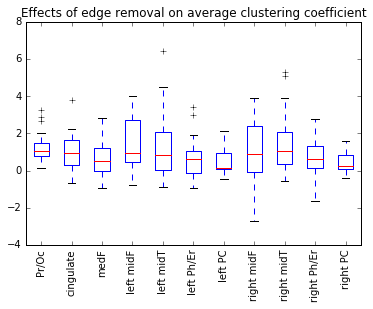

In [16]:
plt.boxplot(removal_cl, labels=reordered_communities)
plt.xticks(range(1,12), reordered_labels, rotation='vertical')
plt.title("Effects of edge removal on average clustering coefficient")

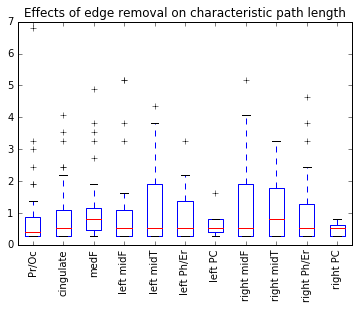

In [17]:
plt.boxplot(removal_spl, labels=reordered_communities)
plt.xticks(range(1,12), reordered_labels, rotation='vertical')
plt.title("Effects of edge removal on characteristic path length")

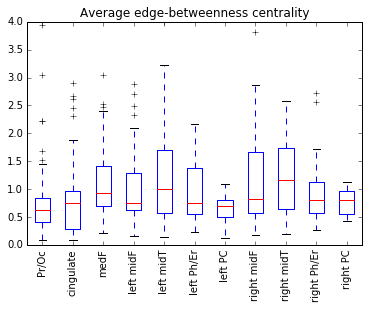

In [18]:
plt.boxplot(removal_ebc, labels=reordered_communities)
plt.xticks(range(1,12), reordered_labels, rotation='vertical')
plt.title("Average edge-betweenness centrality")

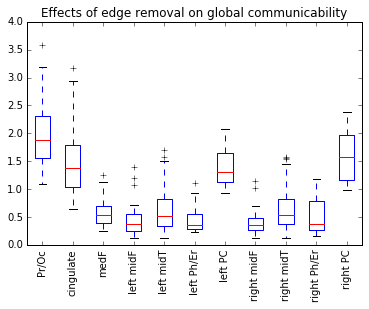

In [19]:
plt.boxplot(removal_gc, labels=reordered_communities)
plt.xticks(range(1,12), reordered_labels, rotation='vertical')
plt.title("Effects of edge removal on global communicability")

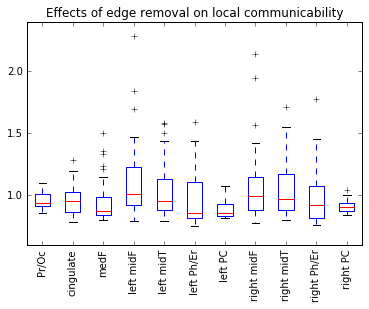

In [20]:
plt.boxplot(removal_lc, labels=reordered_communities)
plt.xticks(range(1,12), reordered_labels, rotation='vertical')
plt.title("Effects of edge removal on local communicability")

In [21]:
# Interior nodes of communities
for community in communities:
    print("There are", len(get_community_interior_nodes(community)), 
          "regions (nodes) contained exclusively within community", community_names[community], ".")

There are 3 regions (nodes) contained exclusively within community Pr/Oc .
There are 1 regions (nodes) contained exclusively within community cingulate .
There are 3 regions (nodes) contained exclusively within community left midT .
There are 3 regions (nodes) contained exclusively within community right midT .
There are 2 regions (nodes) contained exclusively within community medF .
There are 4 regions (nodes) contained exclusively within community right Ph/Er .
There are 5 regions (nodes) contained exclusively within community right midF .
There are 4 regions (nodes) contained exclusively within community left Ph/Er .
There are 4 regions (nodes) contained exclusively within community left midF .
There are 0 regions (nodes) contained exclusively within community right PC .
There are 1 regions (nodes) contained exclusively within community left PC .


In [22]:
# Count number of nodes that do not belong to any specific community
def participation_coeff(node):
    return_value = 1
    for ownership in edge_community_properties[node][2]:
        return_value -= ownership[1] ** 2
    return return_value
num_mult_comm = 0
for node in G:
    if participation_coeff(node)>0:
        num_mult_comm += 1
print("Out of the", len(G), "regions (nodes)", num_mult_comm, "do not belong exclusively to any single community.")

Out of the 68 regions (nodes) 38 do not belong exclusively to any single community.


In [23]:
# prints information for the subgraphs of each community
for community in communities:
    community_subgraph = nx.Graph()
    node_set = get_nodes_in_community(community)
    edge_set = get_edges_in_community(community)
    for node in node_set:
        community_subgraph.add_node(node)
    for edge in edge_set:
        community_subgraph.add_edge(edge[0], edge[1])
    print("Community:", community_names[community])
    print(nx.info(community_subgraph), "\n")

Community: Pr/Oc
Name: 
Type: Graph
Number of nodes: 14
Number of edges: 76
Average degree:  10.8571 

Community: cingulate
Name: 
Type: Graph
Number of nodes: 12
Number of edges: 46
Average degree:   7.6667 

Community: left midT
Name: 
Type: Graph
Number of nodes: 17
Number of edges: 45
Average degree:   5.2941 

Community: right midT
Name: 
Type: Graph
Number of nodes: 17
Number of edges: 43
Average degree:   5.0588 

Community: medF
Name: 
Type: Graph
Number of nodes: 16
Number of edges: 32
Average degree:   4.0000 

Community: right Ph/Er
Name: 
Type: Graph
Number of nodes: 16
Number of edges: 30
Average degree:   3.7500 

Community: right midF
Name: 
Type: Graph
Number of nodes: 15
Number of edges: 30
Average degree:   4.0000 

Community: left Ph/Er
Name: 
Type: Graph
Number of nodes: 16
Number of edges: 29
Average degree:   3.6250 

Community: left midF
Name: 
Type: Graph
Number of nodes: 11
Number of edges: 29
Average degree:   5.2727 

Community: right PC
Name: 
Type: Graph
Nu

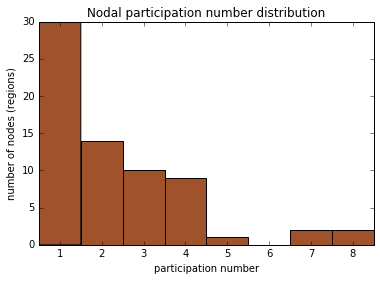

In [24]:
# Generate the historam of participation number of nodes
plt.hist([len(edge_community_properties[node][2]) for node in G.nodes()], bins=8, range=[0.5,8.5], color='sienna')
plt.xlim(0.5, 8.5)
plt.xlabel('participation number')
plt.ylabel('number of nodes (regions)')
plt.title('Nodal participation number distribution')

In [25]:
# Identification of nodes involved in many communities
# This confirms that the regions involved in 7 or 8 communities are hubs corresponding to precuneus and superior frontal.
for node in G.nodes():
    value = len(edge_community_properties[node][2])
    if value >= 5:
        print("The region", region_names[node], "is involved in", value, "communities.")

The region ctx-lh-precuneus
 is involved in 7 communities.
The region ctx-lh-superiorfrontal
 is involved in 8 communities.
The region ctx-rh-precentral
 is involved in 5 communities.
The region ctx-rh-precuneus
 is involved in 7 communities.
The region ctx-rh-superiorfrontal
 is involved in 8 communities.


In [26]:
# Putative hub regions (nodes)
hub_regions = [
    "ctx-lh-superiorfrontal\n",
    "ctx-rh-superiorfrontal\n",
    "ctx-lh-precuneus\n",
    "ctx-rh-precuneus\n",
    "ctx-lh-superiorparietal\n",
    "ctx-rh-superiorparietal\n",
    "ctx-lh-insula\n",
    "ctx-rh-insula\n"
]
hub_dict = {}
hub_set = set()
for node in G.nodes():
    if region_names[node] in hub_regions:
        for region_name in hub_regions:
            if region_name == region_names[node]:
                hub_dict[region_name] = node
                hub_set.add(node)

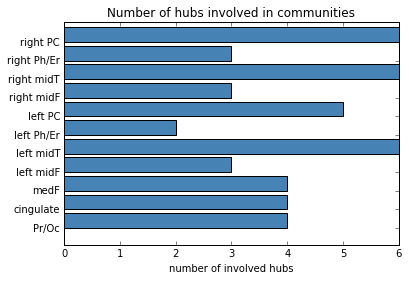

In [27]:
# Number of hubs involved in communities
hub_involvement = []
for community in reordered_communities:
    involvement = 0
    node_set = get_nodes_in_community(community)
    for node in node_set:
        for region_name in hub_regions:
            if hub_dict[region_name] == node:
                involvement += 1
                break
    hub_involvement.append(involvement)
index = np.arange(11)
plt.barh(index+0.4, hub_involvement, color='steelblue')
plt.yticks(index+0.4, reordered_labels, rotation='horizontal')
plt.ylim(-0.5, 11.5)
plt.xlabel('number of involved hubs')
plt.title('Number of hubs involved in communities')

An analysis of participation number of nodes with factors the degree and hub/non-hub status.

In [28]:
total_count = {}
hub_count = {}
participation_number_by_degree = {}
y_total = []
y_err = []
hub_dist = []
nonhub_dist = []
regr_x = []
regr_y = []
for node in G.nodes():
    degree = G.degree(node)
    if degree not in participation_number_by_degree:
        participation_number_by_degree[degree] = []
        total_count[degree] = 0
        hub_count[degree] = 0
    participation_number = len(edge_community_properties[node][2])
    participation_number_by_degree[degree].append(participation_number)
    total_count[degree] += 1
    if node in hub_set:
        hub_count[degree] += 1
        hub_dist.append(participation_number)
        regr_x.append([degree, 1])
        regr_y.append(participation_number)
    else:
        nonhub_dist.append(participation_number)
        regr_x.append([degree, 0])
        regr_y.append(participation_number)
print("The participation numbers of hubs have mean {0:.2f} and standard deviation {1:.2f}".format(np.mean(hub_dist), np.std(hub_dist)))
print("The participation numbers of non-hubs have mean {0:.2f} and standard deviation {1:.2f}".format(np.mean(nonhub_dist), 
                                                                                                      np.std(nonhub_dist)))

regr = linear_model.LinearRegression()
regr.fit(regr_x, regr_y)
print("The coefficient for degree is {0:.2f} and that for hub is {1:.2f}".format(regr.coef_[0], regr.coef_[1]))
#prediction = regr.predict(regr_x)
#residual = (prediction - regr_y)**2/prediction
#regr_x_null = []
#for node in G.nodes():
#    degree = G.degree(node)
#    regr_x_null.append([degree])
#    participation_number = len(edge_community_properties[node][2])
#regr.fit(regr_x_null, regr_y)
#prediction = regr.predict(regr_x_null)
#residual_null = (prediction - regr_y)**2/prediction
#print("The lack-of-fit residual sum of squares is", np.sum(residual_null)-np.sum(residual))

The participation numbers of hubs have mean 5.75 and standard deviation 1.79
The participation numbers of non-hubs have mean 1.88 and standard deviation 1.07
The coefficient for degree is 0.24 and that for hub is 1.41


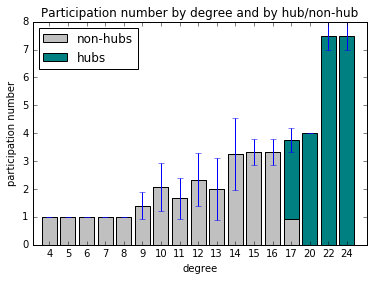

In [29]:
for degree in participation_number_by_degree:
    y_total.append(np.mean(participation_number_by_degree[degree]))
    y_err.append(np.std(participation_number_by_degree[degree]))
avail_deg = [item[0] for item in participation_number_by_degree.items()]
hub_prop = [float(hub_count[degree])/total_count[degree] for degree in hub_count]
index = np.arange(len(avail_deg))
y_hub = [y_total[i]*hub_prop[i] for i in index]
y_nonhub = [y_total[i]*(1-hub_prop[i]) for i in index]
plt.bar(index, y_nonhub, color='silver', label='non-hubs')
plt.bar(index, y_hub, color='teal', bottom=y_nonhub, yerr=y_err, label='hubs')
plt.xticks(index+0.4, avail_deg)
plt.xlim(-0.5,len(index)+0.5)
plt.xlabel('degree')
plt.ylabel('participation number')
plt.legend(loc='upper left')
plt.title('Participation number by degree and by hub/non-hub')